**Score to beat: 0.79425**

# Import statements

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

/tmp/ipykernel_82307/300387039.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.set_option('display.max_columns', None)

# Load data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Check Sizes

In [4]:
train.shape, test.shape

((891, 12), (418, 11))

# Preprocessing

## Outlier Detection

In [5]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

### Visualise Outliers

In [6]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


### Drop Outliers

In [7]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [8]:
train.shape, test.shape

((881, 12), (418, 11))

## Join Train and Test

In [9]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Null Values

### In Total Dataset

In [10]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

### In Train Dataset

In [11]:
train = train.fillna(np.nan)
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

# Feature Analysis

## Numerical Values Heatmap

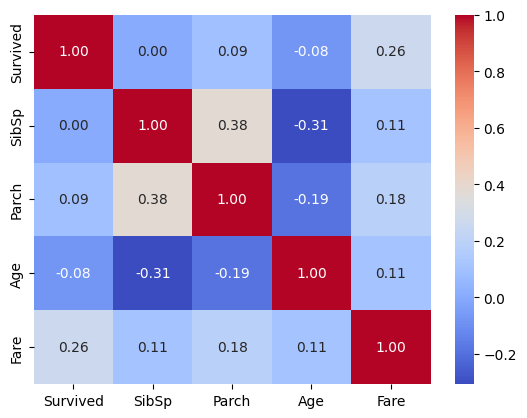

In [12]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

#### Impute Age using:
- Pclass
- SibSp
- Parch

In [13]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/tmp/ipykernel_82307/2077288331.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['Age'].iloc[i] = age_pred
/tmp/ipykernel_82307/2077288331.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

#### Impute Embarked using

- Mode

In [14]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

#### Apply Log to Fare to reduce Skewness

In [15]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

# Feature Engineering

## Name

- Extract Title from name and group into categories
- Drop Name column

In [16]:
def extract_title(row):
    return row.split(',')[1].strip().split('.')[0]

dataset['Title'] = dataset['Name'].apply(extract_title)

In [17]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

## Family Size

- Create a Family size by adding SibSp and Parch
- Create Family Size groups

In [18]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

## Cabins

- Extract first digit for cabin area or Z for unknown

In [19]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

# Encoding

- Embarkation
- Cabins
- Sex

## Sex

In [20]:
dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})

## Embarked

In [21]:
dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

## Cabins

In [22]:
dataset['Cabin'] = dataset['Cabin'].map({'X': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})

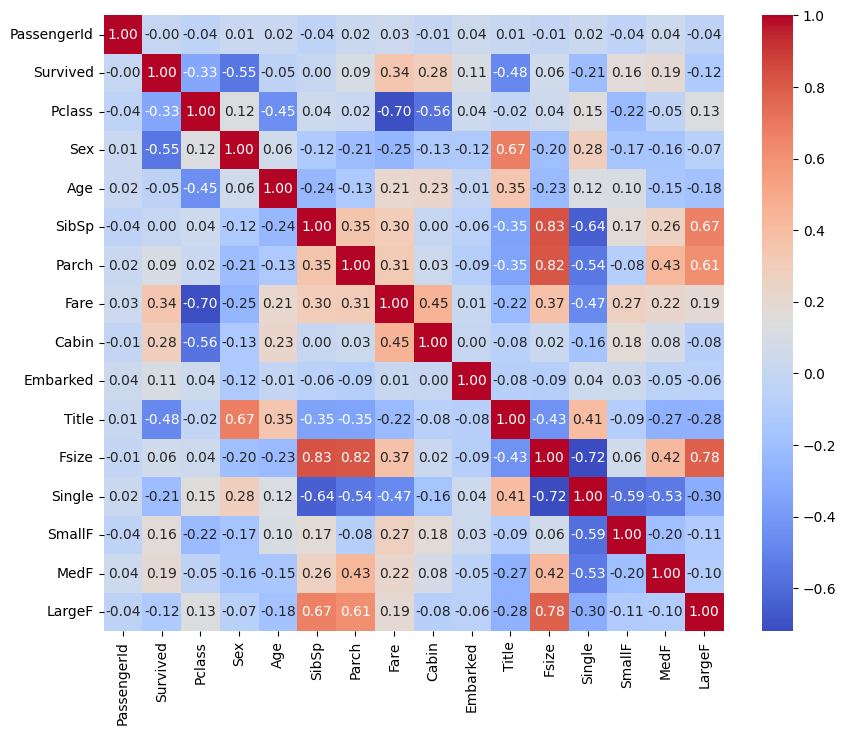

In [23]:
numerical_features = dataset.select_dtypes(include=['number'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
g = sns.heatmap(numerical_features.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

# Drop Columns

- PassengerId
- Ticket
- Fsize
- Name

In [24]:
dataset = dataset.drop(columns=['Name', 'Ticket'])

In [25]:
dataset = dataset.drop(columns=['Fsize', 'SibSp', 'Parch'])

In [26]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Single,SmallF,MedF,LargeF
0,1,0.0,3,1,22.0,1.981001,0,0,2,0,1,0,0
1,2,1.0,1,0,38.0,4.266662,3,1,1,0,1,0,0
2,3,1.0,3,0,26.0,2.070022,0,0,1,1,0,0,0
3,4,1.0,1,0,35.0,3.972177,3,0,1,0,1,0,0
4,5,0.0,3,1,35.0,2.085672,0,0,2,1,0,0,0


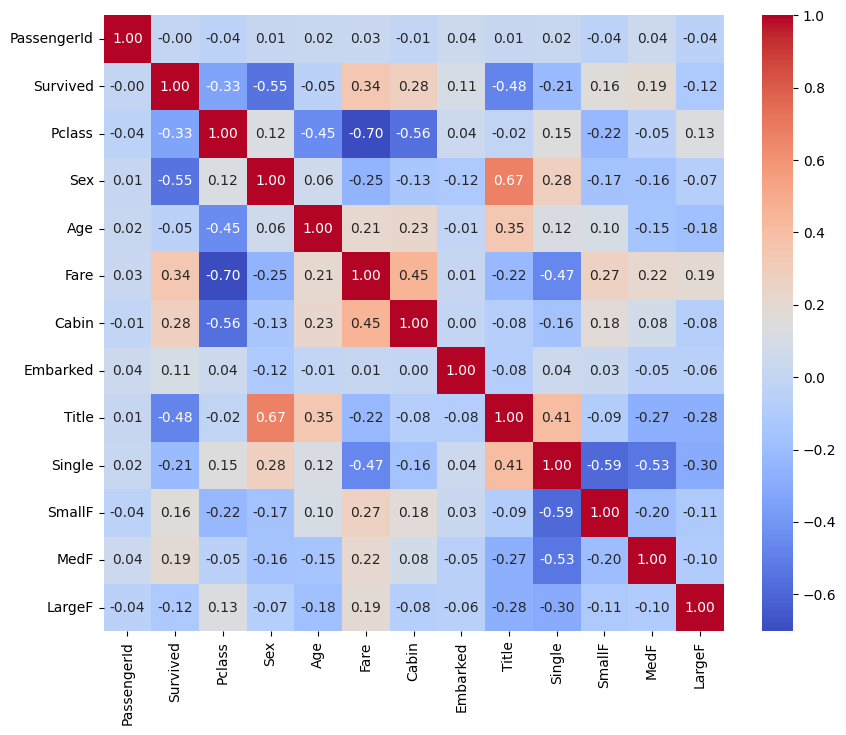

In [27]:
numerical_features = dataset.select_dtypes(include=['number'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
g = sns.heatmap(numerical_features.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [28]:
train = dataset[:train_len]
test = dataset[train_len:]

test.drop(labels=["Survived"],axis = 1,inplace=True)

/tmp/ipykernel_82307/4150595940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


# Save Datasets

In [29]:
train.to_csv('data/preproc_data/train.csv')
test.to_csv('data/preproc_data/test.csv')